In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm catboost


Defaulting to user installation because normal site-packages is not writeable


## 0 - Install dependencies
This cell installs the main libraries used in the notebook.


In [2]:
# 1 — Imports
# Standard data science imports and ML libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import optuna
import xgboost as xgb
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import seaborn as sns


C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1 - Load data
Load the provided `train.csv` and `test.csv` files.


In [3]:
# 2 — Loading datasets
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [4]:
train.drop("id", axis=1, inplace=True)
test.drop("id", axis=1, inplace=True)

## 2 - Identify numeric & categorical columns
We'll list numeric and categorical columns to inspect distributions and to use later.

In [5]:
# 3 — Column type selection
# Keep the core DataFrame names `train` and `test` unchanged (as requested).
num_columns = list(train.select_dtypes(include=[np.float64, np.int64]))  # numeric helpers
cat_columns = list(train.select_dtypes(include="object"))                # categorical helpers


## 3 - Correlation heatmap
Visualize pairwise correlations among numeric features.

<Axes: >

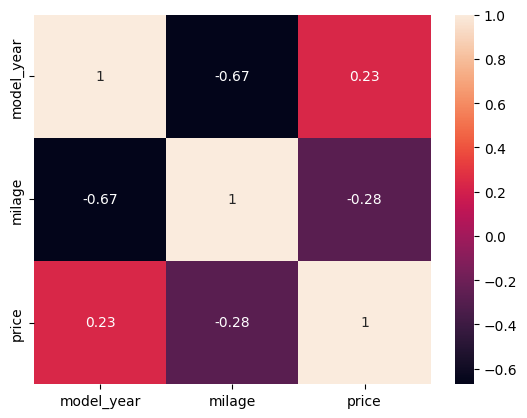

In [6]:
# Correlation heatmap for numeric features
sns.heatmap(train.corr(numeric_only=True), annot=True)


## 4 - Mutual Information (feature relevance)
Use mutual information to estimate how informative each feature is w.r.t the target (`price`).


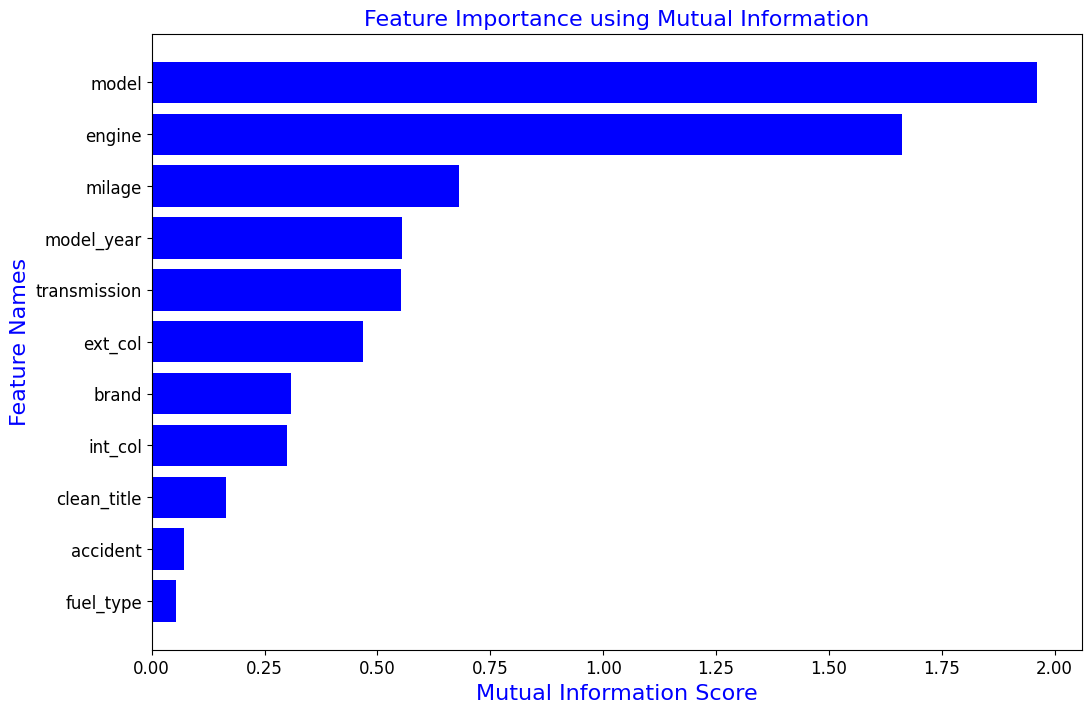

In [7]:
# Mutual information calculation (for each feature)
from sklearn.feature_selection import mutual_info_classif

columns = train.columns[:-1]   # all columns except the last (assumes last is target)
# Target column name (kept same as original)
target_column = 'price'

# Use full dataset (no sampling here)
df_sampled = train

X = df_sampled[columns]
y = df_sampled[target_column]

# Renamed function: compute_mi (was calculate_mi)
def compute_mi(column):
    # If column is categorical, convert to category codes before MI
    if X[column].dtype == 'object':
        X_encoded = X[[column]].apply(lambda col: col.astype('category').cat.codes)
        mi = mutual_info_classif(X_encoded, y, discrete_features=True)
        return mi.sum()
    else:
        # numeric column case
        mi = mutual_info_classif(X[[column]], y, discrete_features=False)
        return mi[0]

# Compute MI score for each feature
mi_scores_renamed = {col: compute_mi(col) for col in columns}

# Convert to DataFrame for sorting & plotting
mi_df = pd.DataFrame(list(mi_scores_renamed.items()), columns=['Feature', 'Mutual Information'])
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)

# Plot MI scores
plt.figure(figsize=(12, 8))  # Increased figure size
plt.barh(
    mi_df['Feature'],
    mi_df['Mutual Information'],
    color='blue'
)
plt.xlabel('Mutual Information Score', fontsize=16, color='blue') 
plt.ylabel('Feature Names', fontsize=16, color='blue') 
plt.title('Feature Importance using Mutual Information', fontsize=16, color='blue') 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().invert_yaxis()
plt.show()


## 5 - Visualize numeric distributions
Plot histograms for each numeric feature to inspect distributions and outliers.


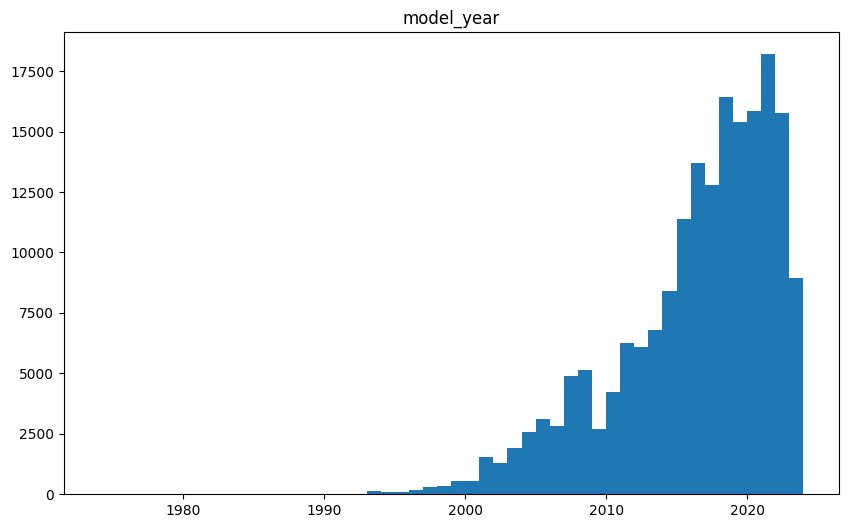

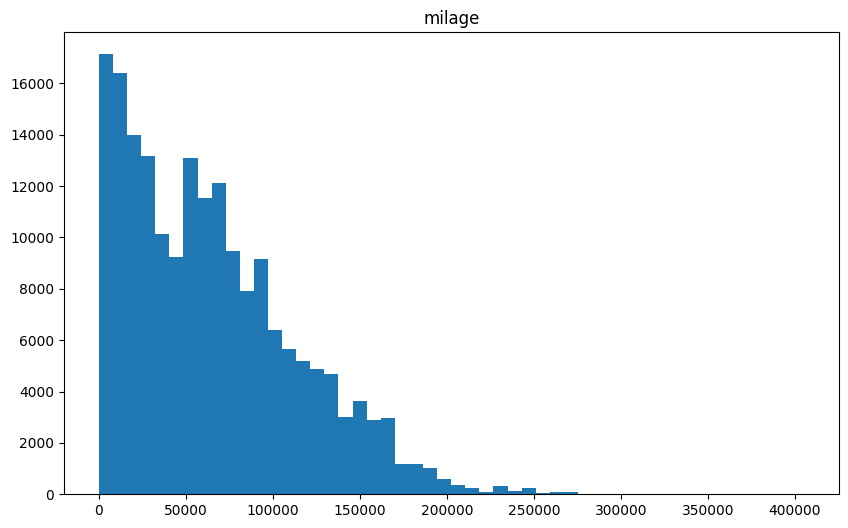

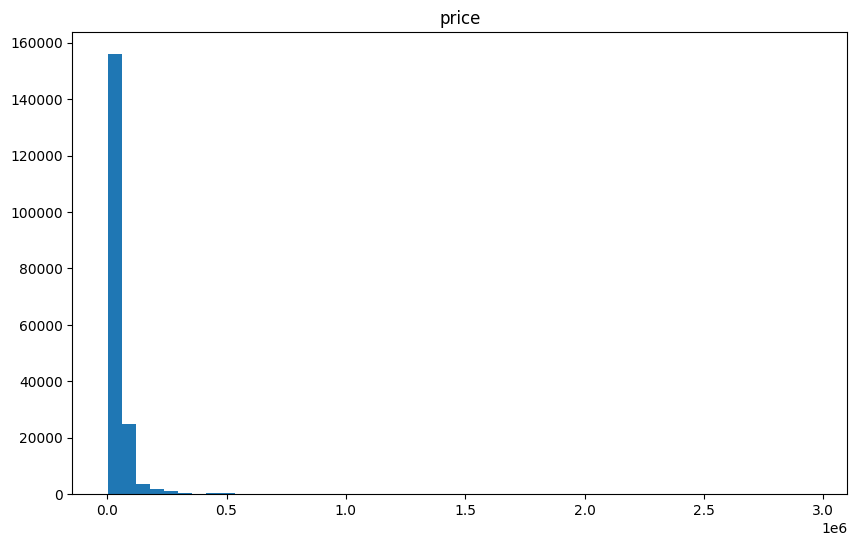

In [8]:
# 6 — Histograms for numeric columns
for col in num_columns:
    plt.figure(figsize=(10, 6))
    plt.title(col)
    plt.hist(train[col], bins=50)


## 6 - Quick check: number of unique `model` values


In [9]:
# Count unique models
len(train["model"].unique())

1897

## 7 - Count plots for small categorical features
Plot countplots for categorical columns with fewer than 15 unique values.


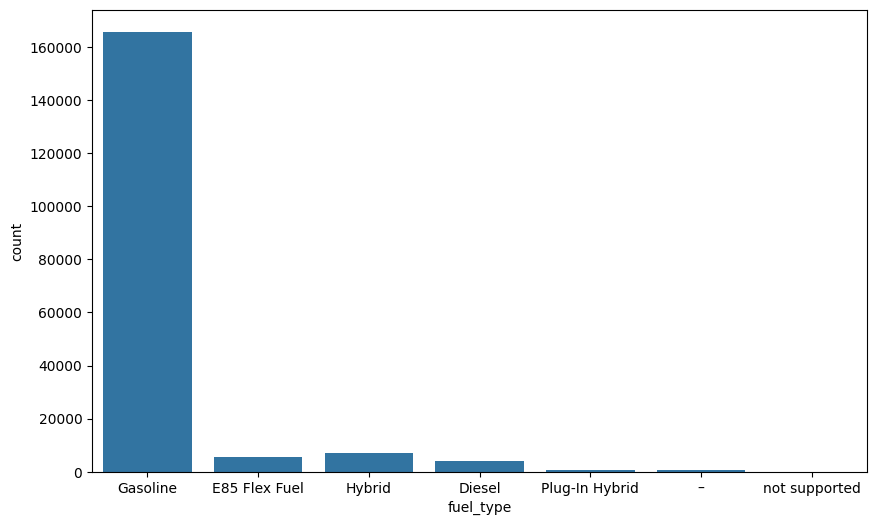

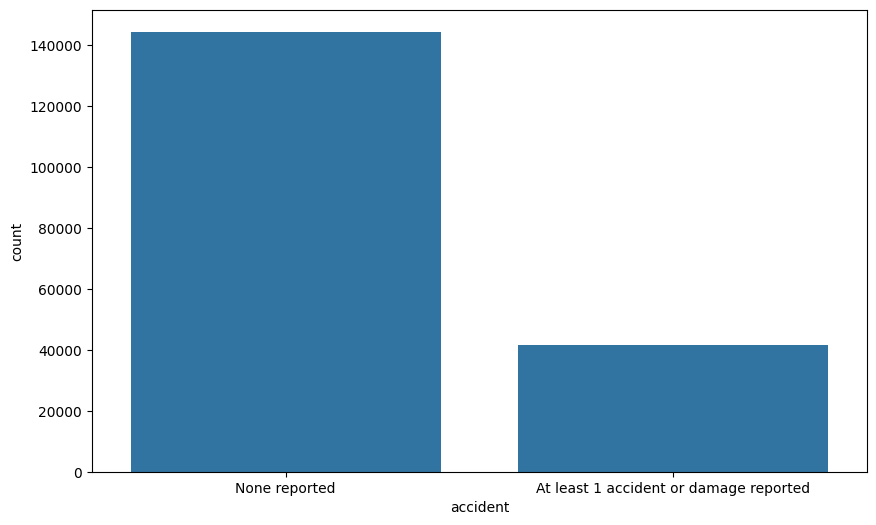

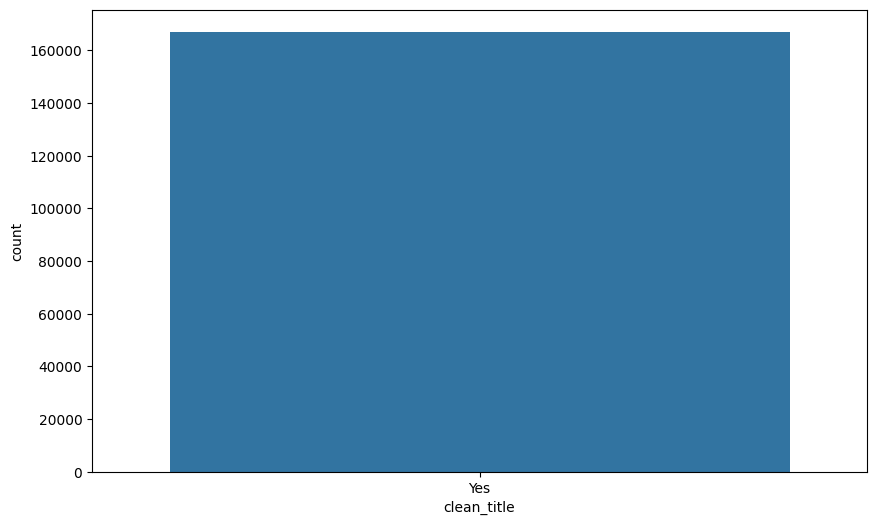

In [10]:
# Categorical columns with limited cardinality
small_cat_cols = [col for col in cat_columns if len(train[col].unique()) < 15]

for col in small_cat_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=train, x=col)


## 8 - Create missing value indicator columns
For features with missing values, create a `_nanflag` column that marks missing rows (1) or not (0).


In [11]:
# Add missing flags to train & test
for col in train.columns:
    if train[col].isna().sum() > 0:
        train[f'{col}_nanflag'] = train[col].isnull().astype(int)

for col in test.columns:
    if test[col].isna().sum() > 0:
        test[f'{col}_nanflag'] = test[col].isnull().astype(int)


In [12]:
# Quick missing value checks (counts)
train.isna().sum(), test.isna().sum()

(brand                      0
 model                      0
 model_year                 0
 milage                     0
 fuel_type               5083
 engine                     0
 transmission               0
 ext_col                    0
 int_col                    0
 accident                2452
 clean_title            21419
 price                      0
 fuel_type_nanflag          0
 accident_nanflag           0
 clean_title_nanflag        0
 dtype: int64,
 brand                      0
 model                      0
 model_year                 0
 milage                     0
 fuel_type               3383
 engine                     0
 transmission               0
 ext_col                    0
 int_col                    0
 accident                1632
 clean_title            14239
 fuel_type_nanflag          0
 accident_nanflag           0
 clean_title_nanflag        0
 dtype: int64)

## 9 - Tokenize engine strings
Split the `engine` text into tokens (words) so we can extract keywords like "Electric", "Turbo", "V6", "L", etc.


In [13]:
# Tokenize engine feature for train & test
engine_splits = [x.split() for x in train["engine"].values]
test_splits = [x.split() for x in test["engine"].values]

## 10 - Build boolean masks for fuel inference
Create boolean lists that indicate whether a token list contains words like "Electric", "Gasoline", "Hybrid", "Diesel", "Flex".


In [14]:
# Build boolean masks (train)
electric_mask = []
gasoline_mask = []
hybrid_mask = []
diesel_mask = []
flex_mask = []

for split in engine_splits:
    if ("Electric" in split) or ("Battery" in split):
        electric_mask.append(True)
    else:
        electric_mask.append(False)

for split in engine_splits:
    if "Gasoline" in split:
        gasoline_mask.append(True)
    else:
        gasoline_mask.append(False)

for split in engine_splits:
    if "Hybrid" in split:
        hybrid_mask.append(True)
    else:
        hybrid_mask.append(False)

for split in engine_splits:
    if "Flex" in split:
        flex_mask.append(True)
    else:
        flex_mask.append(False)

for split in engine_splits:
    if "Diesel" in split:
        diesel_mask.append(True)
    else:
        diesel_mask.append(False)

# 13 — Build boolean masks (test)
electric_mask_test = []
gasoline_mask_test = []
hybrid_mask_test = []
diesel_mask_test = []
flex_mask_test = []

for split in test_splits:
    if ("Electric" in split) or ("Battery" in split):
        electric_mask_test.append(True)
    else:
        electric_mask_test.append(False)

for split in test_splits:
    if "Gasoline" in split:
        gasoline_mask_test.append(True)
    else:
        gasoline_mask_test.append(False)

for split in test_splits:
    if "Hybrid" in split:
        hybrid_mask_test.append(True)
    else:
        hybrid_mask_test.append(False)

for split in test_splits:
    if "Flex" in split:
        flex_mask_test.append(True)
    else:
        flex_mask_test.append(False)

for split in test_splits:
    if "Diesel" in split:
        diesel_mask_test.append(True)
    else:
        diesel_mask_test.append(False)


## 11 - Force Electric fuel type for specific brands
The original code assigns `Electric` to Tesla and Rivian. (Kept the same logic and lines.)


In [15]:
# 14 — Brand-based override for fuel_type (kept identical logic)
train.loc[train["brand"] == "Tesla", "fuel_type"] = "Electric"
train.loc[train["brand"] == "Rivian", "fuel_type"] = "Electric"

test.loc[train["brand"] == "Tesla", "fuel_type"] = "Electric"
test.loc[train["brand"] == "Rivian", "fuel_type"] = "Electric"
# Note: this uses `train["brand"]` in the condition for `test` as in the original notebook.


## 12 - Fill missing `fuel_type` using engine token masks
If `fuel_type` is missing and the engine tokens indicate a type, fill it in.

In [16]:
# Use masks to populate missing fuel_type for train & test
train.loc[electric_mask & train["fuel_type"].isna(), "fuel_type"] = "Electric"
train.loc[gasoline_mask & train["fuel_type"].isna(), "fuel_type"] = "Gasoline"
train.loc[hybrid_mask & train["fuel_type"].isna(), "fuel_type"] = "Hybrid"
train.loc[diesel_mask & train["fuel_type"].isna(), "fuel_type"] = "Diesel"
train.loc[flex_mask & train["fuel_type"].isna(), "fuel_type"] = "Flex"

test.loc[electric_mask_test & test["fuel_type"].isna(), "fuel_type"] = "Electric"
test.loc[gasoline_mask_test & test["fuel_type"].isna(), "fuel_type"] = "Gasoline"
test.loc[hybrid_mask_test & test["fuel_type"].isna(), "fuel_type"] = "Hybrid"
test.loc[diesel_mask_test & test["fuel_type"].isna(), "fuel_type"] = "Diesel"
test.loc[flex_mask_test & test["fuel_type"].isna(), "fuel_type"] = "Flex"

C:\Users\HP\AppData\Local\Temp\ipykernel_13072\2684317845.py:2: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  train.loc[electric_mask & train["fuel_type"].isna(), "fuel_type"] = "Electric"
C:\Users\HP\AppData\Local\Temp\ipykernel_13072\2684317845.py:3: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  train.loc[gasoline_mask & train["fuel_type"].isna(), "fuel_type"] = "Gasoline"
C:\Users\HP\AppData\Local\Temp\ipykernel_13072\2684317845.py:4: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in

## 13 - Fill any remaining null `fuel_type` as Electric


In [17]:
# Final fallback for missing fuel_type
train.loc[train["fuel_type"].isna(), "fuel_type"] = "Electric"
test.loc[test["fuel_type"].isna(), "fuel_type"] = "Electric"


In [18]:
test.isna().sum()

brand                      0
model                      0
model_year                 0
milage                     0
fuel_type                  0
engine                     0
transmission               0
ext_col                    0
int_col                    0
accident                1632
clean_title            14239
fuel_type_nanflag          0
accident_nanflag           0
clean_title_nanflag        0
dtype: int64

## 14 - Fill missing `accident` entries with "None reported"
A simple imputation for the `accident` column.


In [19]:
# Impute accident fields in train & test
train.loc[train["accident"].isna(), "accident"] = "None reported"
test.loc[test["accident"].isna(), "accident"] = "None reported"


## 15 - `clean_title` value counts and fill NaNs
Check and fill missing clean_title values.


In [20]:
# Show distribution of clean_title (original code: prints counts)
train.clean_title.value_counts()

clean_title
Yes    167114
Name: count, dtype: int64

In [21]:
# Fill missing clean_title values with "No"
train.loc[train["clean_title"].isna(), "clean_title"] = "No"
test.loc[test["clean_title"].isna(), "clean_title"] = "No"

In [22]:
train.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,fuel_type_nanflag,accident_nanflag,clean_title_nanflag
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200,0,0,0
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,0,0,0
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900,0,0,0
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000,0,0,0
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500,0,0,0


## 16 - Extract horsepower values of the form `NNNHP` from `engine` tokens
This block looks for tokens matching `^\d+(\.\d+)?HP$` and creates a `horsepower` numeric column.


In [23]:
# Extract horsepower (pattern e.g. '250HP' or '250.0HP')
import re

pattern = re.compile(r'^\d+(\.\d+)?HP$')

hp_list_train = [[word for word in word_list if pattern.match(word)] for word_list in engine_splits]

hp_col_train = []

for hp in hp_list_train:
    if len(hp) == 1:
        # Convert '250HP' or '250.0HP' to numeric (drop decimals)
        hp_col_train.append(np.float64(hp[0].split('.')[0]))
    else:
        hp_col_train.append(np.nan)

hp_col_train = np.array(hp_col_train)
train["horsepower"] = hp_col_train

# Do the same for test set
hp_list_test = [[word for word in word_list if pattern.match(word)] for word_list in test_splits]

hp_col_test = []

for hp in hp_list_test:
    if len(hp) == 1:
        hp_col_test.append(np.float64(hp[0].split('.')[0]))
    else:
        hp_col_test.append(np.nan)

hp_col_test = np.array(hp_col_test)
test["horsepower"] = hp_col_test


In [24]:
# liters is missing

pattern = re.compile(r'^\d+(\.\d+)?L$')

# Process train data
l_list_train = [[word for word in word_list if pattern.match(word)] for word_list in engine_splits]

l_col_train = []

for l in l_list_train:
    if len(l) == 1:
        l_col_train.append(np.float64(l[0][:-1]))  # Remove the 'L' and convert to float
    else:
        l_col_train.append(np.nan)

l_col_train = np.array(l_col_train)
train["engine_liters"] = l_col_train

# Process test data
l_list_test = [[word for word in word_list if pattern.match(word)] for word_list in test_splits]

l_col_test = []

for l in l_list_test:
    if len(l) == 1:
        l_col_test.append(np.float64(l[0][:-1]))  # Remove the 'L' and convert to float
    else:
        l_col_test.append(np.nan)

l_col_test = np.array(l_col_test)
test["engine_liters"] = l_col_test

## 17 - Extract engine liters (e.g., `2.0L`) into `engine_liters`

In [25]:
# 22 — Extract liters value (pattern e.g. '2.0L')
pattern = re.compile(r'^\d+(\.\d+)?L$')

# Process train
l_list_train = [[word for word in word_list if pattern.match(word)] for word_list in engine_splits]
l_col_train = []
for l in l_list_train:
    if len(l) == 1:
        l_col_train.append(np.float64(l[0][:-1]))  # strip trailing 'L'
    else:
        l_col_train.append(np.nan)
l_col_train = np.array(l_col_train)
train["engine_liters"] = l_col_train

# Process test
l_list_test = [[word for word in word_list if pattern.match(word)] for word_list in test_splits]
l_col_test = []
for l in l_list_test:
    if len(l) == 1:
        l_col_test.append(np.float64(l[0][:-1]))
    else:
        l_col_test.append(np.nan)
l_col_test = np.array(l_col_test)
test["engine_liters"] = l_col_test


## 18 - Extract cylinder counts (pattern `V\d+` or plain number)
This block extracts tokens like `V6` or `6` into the `cylinders` column.


In [26]:
# Extract cylinders; pattern matches 'V6' or '6'
import re
import numpy as np

pattern = re.compile(r'^(V\d+|\d+)$')

hp_list_train = [[word for word in word_list if pattern.match(word)] for word_list in engine_splits]

hp_col_train = []

for hp in hp_list_train:
    if len(hp) == 1:
        # convert 'V6' -> '6' via split
        hp_col_train.append(np.float64(hp[0].split('V')[-1]))
    else:
        hp_col_train.append(np.nan)

hp_col_train = np.array(hp_col_train)
train["cylinders"] = hp_col_train

# Test set
hp_list_test = [[word for word in word_list if pattern.match(word)] for word_list in test_splits]

hp_col_test = []

for hp in hp_list_test:
    if len(hp) == 1:
        hp_col_test.append(np.float64(hp[0].split('V')[-1]))
    else:
        hp_col_test.append(np.nan)

hp_col_test = np.array(hp_col_test)
test["cylinders"] = hp_col_test


In [27]:
# Inspect the first 20 rows to ensure the new numeric columns exist
train.head(20)


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,fuel_type_nanflag,accident_nanflag,clean_title_nanflag,horsepower,engine_liters,cylinders
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200,0,0,0,172.0,1.6,4.0
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,0,0,0,252.0,3.9,8.0
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900,0,0,0,320.0,5.3,8.0
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000,0,0,0,420.0,5.0,8.0
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500,0,0,0,208.0,2.0,4.0
5,Audi,A6 2.0T Sport,2018,40950,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,White,–,None reported,Yes,29950,0,0,0,252.0,2.0,4.0
6,Audi,A8 L 3.0T,2016,62200,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Black,Black,None reported,Yes,28500,0,0,0,333.0,3.0,6.0
7,Chevrolet,Silverado 1500 1LZ,2016,102604,E85 Flex Fuel,355.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,White,Gray,None reported,Yes,12500,0,0,0,355.0,5.3,8.0
8,Ford,F-150 XLT,2020,38352,Gasoline,2.7L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,Snowflake White Pearl Metallic,Black,None reported,Yes,62890,0,0,0,NaN,2.7,6.0
9,BMW,M4 Base,2015,74850,Gasoline,425.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Transmission w/Dual Shift Mode,Black,Blue,None reported,Yes,4000,0,0,0,425.0,3.0,6.0


## 19 - Quick inspect: show some Diesel engine rows for brand analysis


In [28]:
# Sample some rows where fuel_type is Diesel (original exploratory step)
train.loc[train["fuel_type"] == "Diesel", "engine"].sample(10)


40347            440.0HP 6.7L 8 Cylinder Engine Diesel Fuel
2093             475.0HP 6.7L 8 Cylinder Engine Diesel Fuel
177737          188.0HP 3.0L V6 Cylinder Engine Diesel Fuel
2164             450.0HP 6.7L 8 Cylinder Engine Diesel Fuel
175343           445.0HP 6.6L 8 Cylinder Engine Diesel Fuel
26298            400.0HP 6.7L 8 Cylinder Engine Diesel Fuel
72713            450.0HP 6.7L 8 Cylinder Engine Diesel Fuel
146215          188.0HP 3.0L V6 Cylinder Engine Diesel Fuel
92866            300.0HP 6.6L 8 Cylinder Engine Diesel Fuel
28905     400.0HP 6.7L Straight 6 Cylinder Engine Diesel...
Name: engine, dtype: object

## 20 - Identify presence of 'Turbo' in engine tokens -> create `turbo` flag


In [29]:
#Create turbo flag in train
turbo_flag = []

for split in engine_splits:
    if 'Turbo' in split:
        turbo_flag.append(1)
    else:
        turbo_flag.append(0)

turbo_flag = np.array(turbo_flag)
train["turbo"] = turbo_flag

# Create turbo flag in test
turbo_flag = []

for split in test_splits:
    if 'Turbo' in split:
        turbo_flag.append(1)
    else:
        turbo_flag.append(0)

turbo_flag = np.array(turbo_flag)
test["turbo"] = turbo_flag


In [30]:
train.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,fuel_type_nanflag,accident_nanflag,clean_title_nanflag,horsepower,engine_liters,cylinders,turbo
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200,0,0,0,172.0,1.6,4.0,0
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,0,0,0,252.0,3.9,8.0,0
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900,0,0,0,320.0,5.3,8.0,0
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000,0,0,0,420.0,5.0,8.0,0
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500,0,0,0,208.0,2.0,4.0,0


## 21 — Mean price by brand (visual)
Use a bar plot to see which brands are most expensive on average.

<Axes: xlabel='brand'>

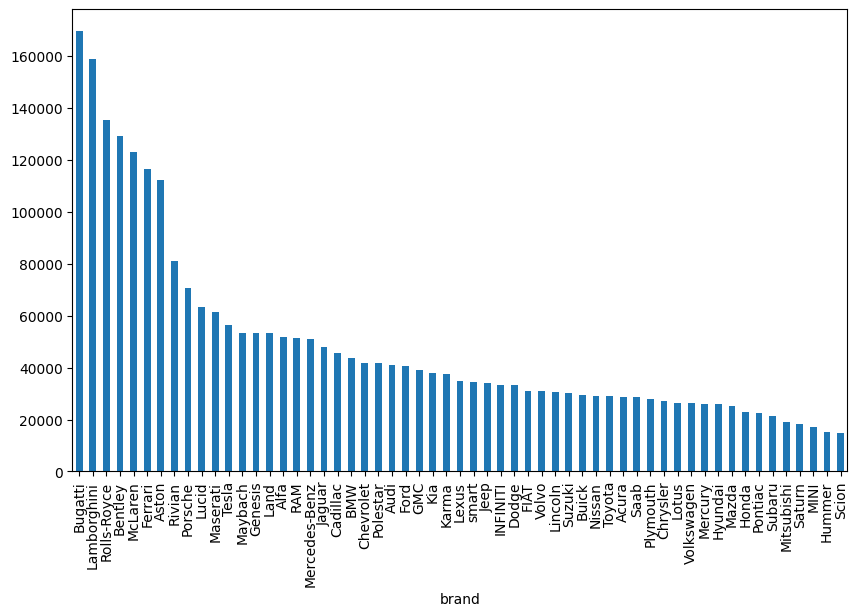

In [31]:
# 28 — Mean price per brand bar chart
plt.figure(figsize=(10, 6))
train.groupby("brand")["price"].mean().sort_values(ascending=False).plot(kind="bar")


## 22 - Create luxury brand binary flag
Flag common exotic/luxury brands.


In [32]:
luxury_brands = ["Bugatti", "Lamborghini", 'Rolls-Royce', "Bentley", "McLaren", "Ferrari", "Aston"]

In [33]:
is_luxury = []
for val in train["brand"]:
    if val in luxury_brands:
        is_luxury.append(1)
    else:
        is_luxury.append(0)
train["luxury_car"] = is_luxury

is_luxury = []
for val in test["brand"]:
    if val in luxury_brands:
        is_luxury.append(1)
    else:
        is_luxury.append(0)
test["luxury_car"] = is_luxury

## 23 - Recreate missing-value flags 


In [34]:
for col in train.columns:
    if train[col].isna().sum() > 0:
        train[f'{col}_missing'] = train[col].isnull().astype(int)

for col in test.columns:
    if test[col].isna().sum() > 0:
        test[f'{col}_missing'] = test[col].isnull().astype(int)

In [35]:
train.head(3)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,...,accident_nanflag,clean_title_nanflag,horsepower,engine_liters,cylinders,turbo,luxury_car,horsepower_missing,engine_liters_missing,cylinders_missing
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,...,0,0,172.0,1.6,4.0,0,0,0,0,0
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,...,0,0,252.0,3.9,8.0,0,0,0,0,0
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,...,0,0,320.0,5.3,8.0,0,0,0,0,0


## 24 - Print all column names 


In [36]:
# Missing count feature

print(train.columns)

# Use the correct nanflag/missing column names available in your dataset
missing_cols = [
    "fuel_type_nanflag", 
    "accident_nanflag", 
    "clean_title_nanflag", 
    "horsepower_missing", 
    "engine_liters_missing", 
    "cylinders_missing"
]

# Sum across these binary flags to get a single feature
train['missing_count'] = train[missing_cols].sum(axis=1)
test['missing_count']  = test[missing_cols].sum(axis=1)


Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price', 'fuel_type_nanflag', 'accident_nanflag', 'clean_title_nanflag',
       'horsepower', 'engine_liters', 'cylinders', 'turbo', 'luxury_car',
       'horsepower_missing', 'engine_liters_missing', 'cylinders_missing'],
      dtype='object')


In [37]:
train.isna().sum()

brand                        0
model                        0
model_year                   0
milage                       0
fuel_type                    0
engine                       0
transmission                 0
ext_col                      0
int_col                      0
accident                     0
clean_title                  0
price                        0
fuel_type_nanflag            0
accident_nanflag             0
clean_title_nanflag          0
horsepower               33259
engine_liters            14214
cylinders                21759
turbo                        0
luxury_car                   0
horsepower_missing           0
engine_liters_missing        0
cylinders_missing            0
missing_count                0
dtype: int64

<Axes: ylabel='Frequency'>

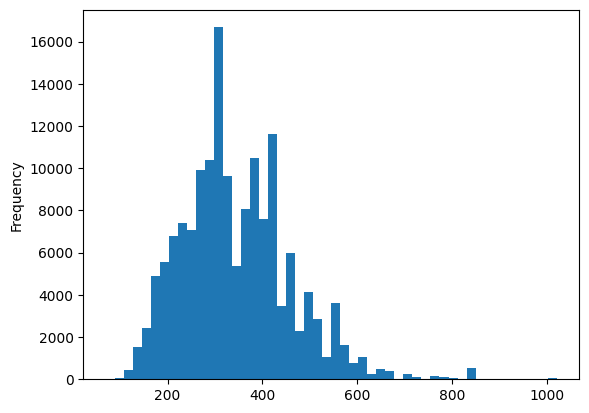

In [38]:
train["horsepower"].plot(kind="hist", bins=50)

<Axes: ylabel='Frequency'>

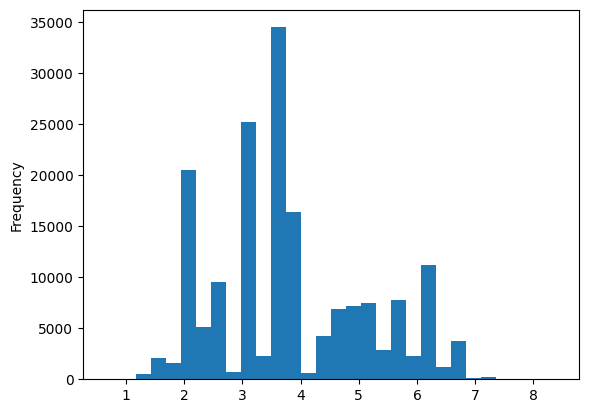

In [39]:
train["engine_liters"].plot(kind="hist", bins = 30)

In [40]:
# Fix obvious cylinder value (original logic: convert 120.0 -> 12.0)
train.loc[train["cylinders"] == 120.0, "cylinders"] = 12.0

0         4.0
1         8.0
2         8.0
3         8.0
4         4.0
         ... 
188528    8.0
188529    6.0
188530    8.0
188531    NaN
188532    4.0
Name: cylinders, Length: 188533, dtype: float64

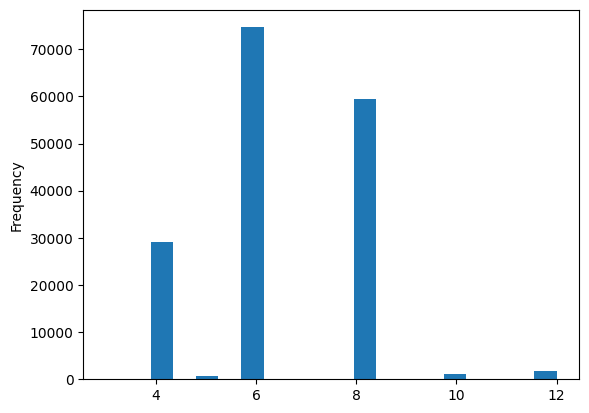

In [41]:
train["cylinders"].plot(kind="hist", bins = 20)
train["cylinders"]

## 26 - Impute numeric engine features using medians/mode
Fill missing horsepower, engine_liters, and cylinders using medians / mode as in the original notebook.


In [42]:
# Impute missing engine-related numeric columns for train
hp_median = train["horsepower"].median()
train.loc[train["horsepower"].isna(), "horsepower"] = hp_median

liters_median = train["engine_liters"].median()
train.loc[train["engine_liters"].isna(), "engine_liters"] = liters_median

cylinders_mode = train["cylinders"].mode()
train.loc[train["cylinders"].isna(), "cylinders"] = cylinders_mode[0]


In [43]:
# 38 — Do the same imputations for the test set
hp_median = test["horsepower"].median()
test.loc[test["horsepower"].isna(), "horsepower"] = hp_median

liters_median = test["engine_liters"].median()
test.loc[test["engine_liters"].isna(), "engine_liters"] = liters_median

cylinders_mode = test["cylinders"].mode()
test.loc[test["cylinders"].isna(), "cylinders"] = cylinders_mode[0]


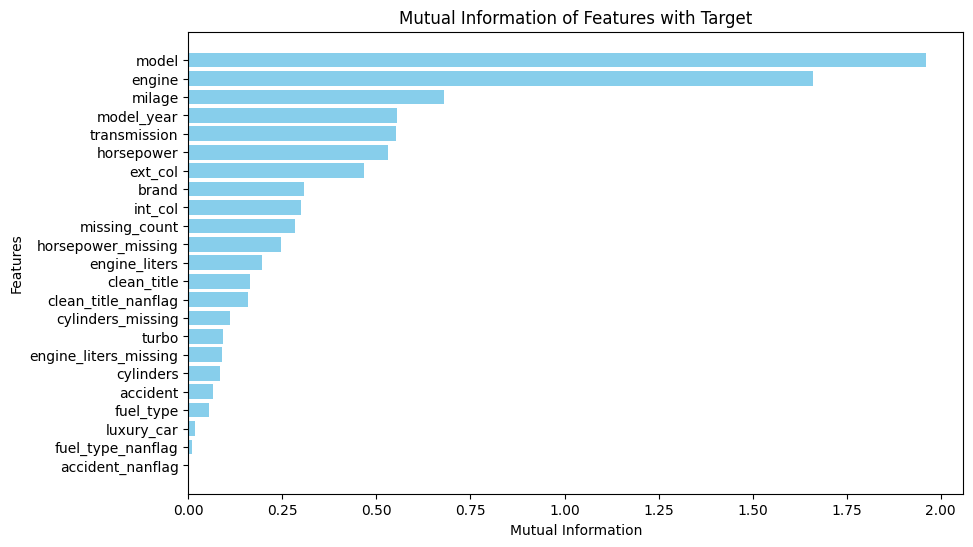

In [44]:
# 39 — Mutual information (repeat block; preserved)
from sklearn.feature_selection import mutual_info_classif

columns = train.drop("price", axis=1).columns
# Target column
target_column = 'price'

# Use full dataset
df_sampled = train

X = df_sampled[columns]
y = df_sampled[target_column]

# compute_mi reused
def compute_mi(column):
    if X[column].dtype == 'object':
        X_encoded = X[[column]].apply(lambda col: col.astype('category').cat.codes)
        mi = mutual_info_classif(X_encoded, y, discrete_features=True)
        return mi.sum()
    else:
        mi = mutual_info_classif(X[[column]], y, discrete_features=False)
        return mi[0]

mi_scores_renamed = {col: compute_mi(col) for col in columns}

mi_df = pd.DataFrame(list(mi_scores_renamed.items()), columns=['Feature', 'Mutual Information'])
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(mi_df['Feature'], mi_df['Mutual Information'], color='skyblue')
plt.xlabel('Mutual Information')
plt.ylabel('Features')
plt.title('Mutual Information of Features with Target')
plt.gca().invert_yaxis()
plt.show()


## 28 - XGBoost feature importance (preprocessing + training)
Convert object columns to 'category' dtype and fit an XGBoost regressor to inspect feature importances.


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

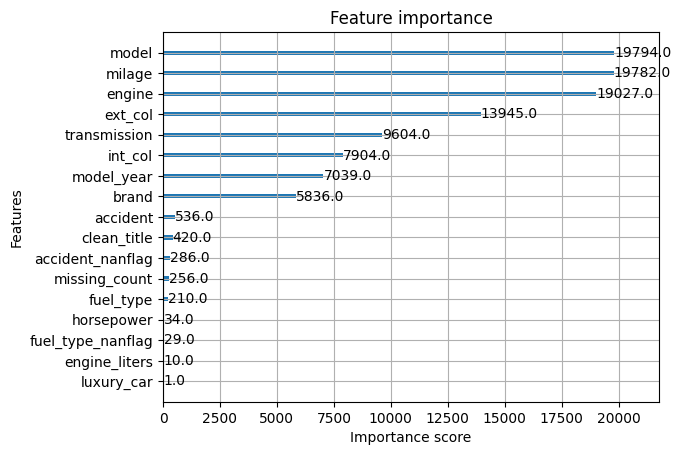

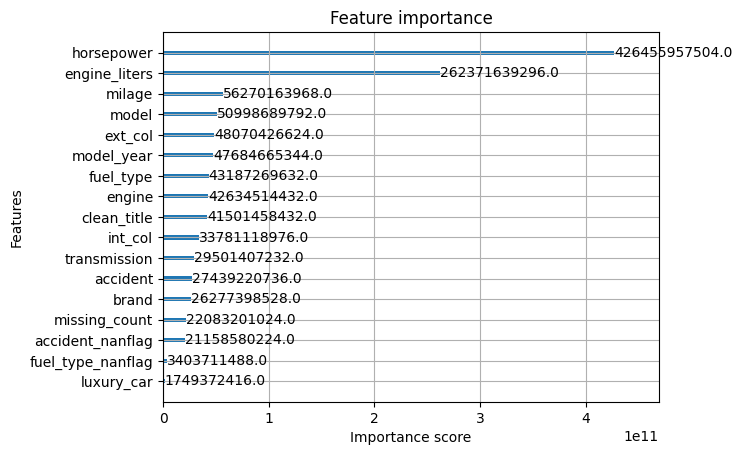

In [45]:
# Create training/validation split and fit XGBRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# Convert object dtypes in train to categorical for XGBoost categorical handling
for col in train.columns:
    if train[col].dtype == 'object':
        train[col] = train[col].astype('category')

X_train, X_val, y_train, y_val = train_test_split(train.drop("price", axis=1), train["price"], test_size=0.2, random_state=42)

# Using enable_categorical=True for XGBoost native handling of categorical columns
xgb_model = XGBRegressor(n_estimators=1000, max_depth=7, learning_rate=0.1, random_state=42, n_jobs=-1, enable_categorical=True)

xgb_model.fit(X_train, y_train)

# Plot feature importance (weight and gain)
xgb.plot_importance(xgb_model, importance_type="weight")
xgb.plot_importance(xgb_model, importance_type="gain")


In [46]:
train.drop(["fuel_type_missing", "luxury_car"], axis=1, inplace=True, errors="ignore")
test.drop(["fuel_type_missing", "luxury_car"], axis=1, inplace=True, errors="ignore")


In [47]:
train.nunique()

brand                      57
model                    1897
model_year                 34
milage                   6651
fuel_type                   9
engine                   1117
transmission               52
ext_col                   319
int_col                   156
accident                    2
clean_title                 2
price                    1569
fuel_type_nanflag           2
accident_nanflag            2
clean_title_nanflag         2
horsepower                348
engine_liters              61
cylinders                   7
turbo                       2
horsepower_missing          2
engine_liters_missing       2
cylinders_missing           2
missing_count               7
dtype: int64

## 30 - Prepare full train and test matrices
We'll create `X_trainval`, `y_trainval` and `X_test` as in the original flow.


In [48]:
#  Prepare features and target
X_trainval, y_trainval = train.drop("price", axis=1), train["price"]
X_test = test


In [49]:
# Make a train/val split 
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)


In [50]:
!pip install category_encoders

Defaulting to user installation because normal site-packages is not writeable


## Target encoding for high-cardinality categoricals
Uses `category_encoders.TargetEncoder` to encode selected categorical columns.


In [51]:
# 45 — Target encoding 
from category_encoders import TargetEncoder
tg_cols = ["brand", "model", "engine", "transmission", "ext_col", "int_col"]

te = TargetEncoder(cols=tg_cols)

# Apply target encoder to training and validation splits
tg_df = te.fit_transform(X_train[tg_cols], y_train)
X_train[tg_cols] = tg_df

tg_df = te.fit_transform(X_val[tg_cols], y_val)
X_val[tg_cols] = tg_df

tg_df = te.fit_transform(X_trainval[tg_cols], y_trainval)
X_trainval[tg_cols] = tg_df

tg_df = te.transform(X_test[tg_cols])
X_test[tg_cols] = tg_df


## 32 - Preprocessing pipeline: scaling + encoding
Construct a ColumnTransformer to scale numeric features, one-hot encode `fuel_type`, and ordinal-encode some categorical flags.


In [52]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

# Numerical columns
num_cols = [
    "model_year", 
    "milage", 
    "horsepower", 
    "engine_liters", 
    "cylinders", 
    "missing_count"
]

# One-hot encode for fuel_type
ohe_cols = ["fuel_type"]

# Ordinal columns (flags + categorical-like binary features)
ord_cols = [
    "accident", 
    "clean_title", 
    "accident_nanflag", 
    "clean_title_nanflag", 
    "fuel_type_nanflag",
    "turbo", 
    "horsepower_missing", 
    "engine_liters_missing", 
    "cylinders_missing"
]

# Pipelines
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

ohe_pipeline = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown="ignore"))
])

ord_pipeline = Pipeline([
    ('ord_enc', OrdinalEncoder())
])

# Column transformer
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('ohe', ohe_pipeline, ohe_cols),
    ('ord', ord_pipeline, ord_cols)
])


## 33 - Fit/transform using preprocessor to create final numeric matrices
We transform train, val, trainval, and test datasets.


In [53]:
# Automatically pick up *_missing or *_nanflag columns
flag_cols = [c for c in train.columns if c.endswith("_missing") or c.endswith("_nanflag")]

num_cols = [
    "model_year", "milage", "horsepower", "engine_liters", "cylinders",
    "missing_count"
] + flag_cols


In [54]:
# 47 — Apply preprocessor and convert to DataFrame to keep feature names
X_train_proc = pd.DataFrame(preprocessor.fit_transform(X_train), columns=preprocessor.get_feature_names_out())
X_val_proc = pd.DataFrame(preprocessor.transform(X_val), columns=preprocessor.get_feature_names_out())
X_trainval_proc = pd.DataFrame(preprocessor.fit_transform(X_trainval), columns=preprocessor.get_feature_names_out())
X_test_proc = pd.DataFrame(preprocessor.transform(X_test), columns=preprocessor.get_feature_names_out())


In [55]:
len(X_train_proc), len(X_val_proc), len(X_trainval_proc)

(150826, 37707, 188533)

## 34 - Create XGBoost DMatrix objects for training & validation
We use `enable_categorical=True` for XGBoost support of categorical


In [56]:
# Convert processed data to xgboost DMatrix format
dX_train = xgb.DMatrix(data=X_train_proc, label=y_train, enable_categorical=True)
dX_val = xgb.DMatrix(data=X_val_proc, label=y_val, enable_categorical=True)
dX_trainval = xgb.DMatrix(data=X_trainval_proc, label=y_trainval, enable_categorical=True)
dX_test = xgb.DMatrix(data=X_test_proc, enable_categorical=True)


In [57]:
# Base params for XGBoost
metric = 'rmse'

base_params = {
    'objective': 'reg:squarederror',
    'eval_metric': metric,
}


In [58]:
from sklearn.metrics import mean_squared_error

def score_model(model: xgb.core.Booster, dmat: xgb.core.DMatrix) -> float:
    y_true = dmat.get_label()
    y_pred = model.predict(dmat)
    return mean_squared_error(y_true, y_pred, squared=False)


## 36 - Quick XGBoost training with higher learning rate (stage 1)
This trains a quick model and prints elapsed time

In [59]:
# Train a base XGBoost model (fast)
import time
learning_rate = 0.3

params = {
    'tree_method': 'approx',
    'learning_rate': learning_rate
}

params.update(base_params)
tic = time.time()
model = xgb.train(params=params, dtrain=dX_train,
                  evals=[(dX_train, 'train'), (dX_val, 'valid')],
                  num_boost_round=10000,
                  early_stopping_rounds=50,
                  verbose_eval=0)
print(f"{time.time() - tic:.1f} seconds")


2.0 seconds


## 37 - Optuna objective for XGBoost hyperparameter tuning
We use Optuna with XGBoost and pruning callback.


In [60]:
# Define Optuna objective for XGBoost hyperparameter search
def objective(trial):
    params = {
        'tree_method': trial.suggest_categorical('tree_method', ['approx', 'hist']),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 250),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.1, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 25, log=True),
        'learning_rate': learning_rate,
    }
    num_boost_round = 10000
    params.update(base_params)
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f"valid-{metric}")

    model = xgb.train(params=params, dtrain=dX_train, num_boost_round=num_boost_round,
    evals=[(dX_train, 'train'), (dX_val, 'valid')],
    early_stopping_rounds=50,
    verbose_eval=0,
    callbacks=[pruning_callback])
    trial.set_user_attr('best_iteration', model.best_iteration)
    return model.best_score


In [61]:
!pip install optuna-integration[xgboost]

Defaulting to user installation because normal site-packages is not writeable


In [62]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2025-09-14 21:50:32,459] A new study created in memory with name: no-name-e91d5661-d0bb-4f3f-82da-2f4c1968b4ca
[I 2025-09-14 21:50:34,895] Trial 0 finished with value: 68258.91028584873 and parameters: {'tree_method': 'approx', 'max_depth': 8, 'min_child_weight': 60, 'subsample': 0.8272760669876831, 'colsample_bynode': 0.6456718817275385, 'reg_lambda': 0.5943768913791997}. Best is trial 0 with value: 68258.91028584873.
[I 2025-09-14 21:50:38,203] Trial 1 finished with value: 68224.63482444194 and parameters: {'tree_method': 'approx', 'max_depth': 6, 'min_child_weight': 247, 'subsample': 0.9611840916432566, 'colsample_bynode': 0.5442878538592256, 'reg_lambda': 0.07543975484518965}. Best is trial 1 with value: 68224.63482444194.
[I 2025-09-14 21:50:42,266] Trial 2 finished with value: 68228.16883421435 and parameters: {'tree_method': 'approx', 'max_depth': 12, 'min_child_weight': 161, 'subsample': 0.6308563835341487, 'colsample_bynode': 0.3090279927930318, 'reg_lambda': 0.010021792776

In [63]:
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)
tic = time.time()
while time.time() - tic < 300:
    study.optimize(objective, n_trials=1)

[I 2025-09-14 21:51:59,631] A new study created in memory with name: no-name-8898fbe0-c3fc-490b-b815-1a73a398ee95
[I 2025-09-14 21:52:02,261] Trial 0 finished with value: 68403.6227021269 and parameters: {'tree_method': 'hist', 'max_depth': 10, 'min_child_weight': 150, 'subsample': 0.24041677639819287, 'colsample_bynode': 0.2403950683025824, 'reg_lambda': 0.001800728515054226}. Best is trial 0 with value: 68403.6227021269.
[I 2025-09-14 21:52:05,382] Trial 1 finished with value: 69456.50648884712 and parameters: {'tree_method': 'approx', 'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.9729188669457949, 'colsample_bynode': 0.8491983767203796, 'reg_lambda': 0.008587261143813469}. Best is trial 0 with value: 68403.6227021269.
[I 2025-09-14 21:52:07,806] Trial 2 finished with value: 68266.81463501503 and parameters: {'tree_method': 'hist', 'max_depth': 6, 'min_child_weight': 132, 'subsample': 0.48875051677790415, 'colsample_bynode': 0.36210622617823773, 'reg_lambda': 0.4907861801695

In [64]:
# Stage 2: lower learning rate and train with best params found
low_eta = 0.01

params = {}
params.update(base_params)
params.update(study.best_trial.params)
params['learning_rate'] = low_eta
model_stage2 = xgb.train(params=params,
                        dtrain=dX_train,
                        num_boost_round=10000,
                        evals=[(dX_train, 'train'),(dX_val, 'valid')],
                        early_stopping_rounds=50,
                        verbose_eval=0)


In [65]:
# Save best iteration and params to reuse later
xgb_boost_rounds = model_stage2.best_iteration
xgb_best_params = params
xgb_boost_rounds

804

In [66]:
# Prepare CatBoost parameters and train a CatBoostRegressor (original block uses loss_function variable name slightly different)
metric = 'RMSE'

base_params = {
    'loss_function': metric
}

best xgb params

{'objective': 'reg:squarederror',
 'eval_metric': 'rmse',
 'tree_method': 'hist',
 'max_depth': 10,
 'min_child_weight': 250,
 'subsample': 0.8798706803142061,
 'colsample_bynode': 0.4710525279337534,
 'reg_lambda': 0.010149060427718995,
 'learning_rate': 0.01}

 xgb_boost_rounds = 538

## 38 - CatBoost quick training using Pool
Create CatBoost pools and run a quick training.


In [67]:
from catboost import CatBoostRegressor, Pool
import time

train_pool = Pool(data=X_train_proc, label=y_train)
eval_pool = Pool(data=X_val_proc, label=y_val)

eta = 0.3

params = {
    'learning_rate': eta
}

params.update(base_params)
cat_model = CatBoostRegressor(**params, iterations=10000, use_best_model=True, od_type='Iter', od_wait=50)
tic = time.time()
cat_model.fit(train_pool, eval_set=eval_pool)
t_delta = time.time() - tic

print(t_delta)

0:	learn: 77521.9050174	test: 72131.9507505	best: 72131.9507505 (0)	total: 270ms	remaining: 44m 56s
1:	learn: 76121.0366720	test: 70655.9736993	best: 70655.9736993 (1)	total: 291ms	remaining: 24m 13s
2:	learn: 75393.9212315	test: 69920.5355113	best: 69920.5355113 (2)	total: 311ms	remaining: 17m 15s
3:	learn: 74904.7894741	test: 69382.0806484	best: 69382.0806484 (3)	total: 333ms	remaining: 13m 53s
4:	learn: 74654.8642750	test: 69123.9193933	best: 69123.9193933 (4)	total: 352ms	remaining: 11m 44s
5:	learn: 74498.7328953	test: 68955.4169653	best: 68955.4169653 (5)	total: 374ms	remaining: 10m 22s
6:	learn: 74333.8352887	test: 68752.7236021	best: 68752.7236021 (6)	total: 393ms	remaining: 9m 20s
7:	learn: 74217.6736686	test: 68703.7335903	best: 68703.7335903 (7)	total: 421ms	remaining: 8m 45s
8:	learn: 74119.4550255	test: 68611.3348393	best: 68611.3348393 (8)	total: 442ms	remaining: 8m 10s
9:	learn: 74054.4550413	test: 68596.8838269	best: 68596.8838269 (9)	total: 464ms	remaining: 7m 43s
10:	

## 39 - Optuna for CatBoost hyperparameter tuning.


In [68]:
# 60 — CatBoost Optuna objective
import catboost as cb
from sklearn.metrics import mean_squared_error, root_mean_squared_error
import optuna

def objective(trial):
    params = {
        "iterations": 1000,
        "learning_rate": 0.3,
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = cb.CatBoostRegressor(**params, silent=True, use_best_model=True, od_type='Iter', od_wait=50)
    model.fit(train_pool, eval_set=eval_pool)
    predictions = model.predict(X_val_proc)
    rmse = root_mean_squared_error(y_val, predictions, squared=False)
    return rmse


In [69]:
!pip install --upgrade scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [70]:
import numpy as np

def objective(trial):
    params = {
        "iterations": 1000,
        "learning_rate": 0.3,
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = cb.CatBoostRegressor(
        **params,
        silent=True,
        use_best_model=True,
        od_type='Iter',
        od_wait=50
    )
    model.fit(train_pool, eval_set=eval_pool)
    
    predictions = model.predict(X_val_proc)
    mse = mean_squared_error(y_val, predictions)   # no `squared` here
    rmse = np.sqrt(mse)
    
    return rmse


In [71]:

study = optuna.create_study(direction='minimize')

tic = time.time()

while time.time() - tic < 300:
    study.optimize(objective, n_trials=1)

[I 2025-09-14 22:17:54,108] A new study created in memory with name: no-name-4374ed69-75d1-4155-bf19-3b2e4ea4026d
[I 2025-09-14 22:18:03,970] Trial 0 finished with value: 69042.35160296231 and parameters: {'depth': 1, 'subsample': 0.9947312207632075, 'colsample_bylevel': 0.111387220793897, 'min_data_in_leaf': 50}. Best is trial 0 with value: 69042.35160296231.
[I 2025-09-14 22:18:09,139] Trial 1 finished with value: 68233.90911799004 and parameters: {'depth': 3, 'subsample': 0.41919138708287496, 'colsample_bylevel': 0.2632704268234622, 'min_data_in_leaf': 9}. Best is trial 1 with value: 68233.90911799004.
[I 2025-09-14 22:18:15,714] Trial 2 finished with value: 68291.79771757859 and parameters: {'depth': 2, 'subsample': 0.4343385609981019, 'colsample_bylevel': 0.28678284701562334, 'min_data_in_leaf': 8}. Best is trial 1 with value: 68233.90911799004.
[I 2025-09-14 22:18:19,667] Trial 3 finished with value: 68284.20555413605 and parameters: {'depth': 4, 'subsample': 0.6923641868037801, 

In [73]:
# Print best hyperparameters and best value
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'depth': 5, 'subsample': 0.059181184380684204, 'colsample_bylevel': 0.2743337548705592, 'min_data_in_leaf': 44}
Best RMSE: 68218.30646489405


In [74]:
# Set optimal params, lower the learning rate and retrain a final CatBoost model 
optimal_params = study.best_params
optimal_params["learning_rate"] = 0.01
cat_model = CatBoostRegressor(**optimal_params, iterations=10000, use_best_model=True, od_type='Iter', od_wait=50)
cat_model.fit(train_pool, eval_set=eval_pool)


0:	learn: 79768.4437222	test: 74490.2721545	best: 74490.2721545 (0)	total: 11.3ms	remaining: 1m 53s
1:	learn: 79702.6859840	test: 74416.9847379	best: 74416.9847379 (1)	total: 25.8ms	remaining: 2m 9s
2:	learn: 79627.1698406	test: 74334.7224058	best: 74334.7224058 (2)	total: 36.7ms	remaining: 2m 2s
3:	learn: 79563.2297006	test: 74265.5394653	best: 74265.5394653 (3)	total: 48.6ms	remaining: 2m 1s
4:	learn: 79492.0506258	test: 74190.8585877	best: 74190.8585877 (4)	total: 59.6ms	remaining: 1m 59s
5:	learn: 79418.1582051	test: 74111.2881245	best: 74111.2881245 (5)	total: 74.9ms	remaining: 2m 4s
6:	learn: 79340.1832382	test: 74028.7983640	best: 74028.7983640 (6)	total: 86.7ms	remaining: 2m 3s
7:	learn: 79270.4969429	test: 73954.5987802	best: 73954.5987802 (7)	total: 101ms	remaining: 2m 6s
8:	learn: 79201.5576959	test: 73880.2411095	best: 73880.2411095 (8)	total: 114ms	remaining: 2m 6s
9:	learn: 79129.9669917	test: 73803.4508938	best: 73803.4508938 (9)	total: 125ms	remaining: 2m 5s
10:	learn: 

In [75]:
# Show chosen optimal parameters (keeps original variable)
optimal_params

{'depth': 5,
 'subsample': 0.059181184380684204,
 'colsample_bylevel': 0.2743337548705592,
 'min_data_in_leaf': 44,
 'learning_rate': 0.01}

best catboost params:

{'depth': 4,
 'subsample': 0.9629275021934809,
 'colsample_bylevel': 0.3719662939757698,
 'min_data_in_leaf': 46,
 'learning_rate': 0.01}

 best iters = 2038

## 40 - Final XGBoost training using found best params
Fit an XGBRegressor with best params and number of rounds found earlier.


In [76]:
# Train a final XGBRegressor with obtained parameters
from xgboost import XGBRegressor

xgb_final = XGBRegressor(**xgb_best_params, n_estimators=xgb_boost_rounds)

xgb_final.fit(X_train_proc, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,0.7749551250626112
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'rmse'


In [77]:
# Evaluate on validation set
y_pred = xgb_final.predict(X_val_proc)

mse = mean_squared_error(y_val, y_pred) 
rmse = np.sqrt(mse)  # convert to RMSE
print(rmse)

68140.30889275452


In [78]:
# Show the best parameters found for both models (this was in original as a printed dictionary)
xgb_best_params = {'objective': 'reg:squarederror',
 'eval_metric': 'rmse',
 'tree_method': 'hist',
 'max_depth': 10,
 'min_child_weight': 250,
 'subsample': 0.8798706803142061,
 'colsample_bynode': 0.4710525279337534,
 'reg_lambda': 0.010149060427718995,
 'learning_rate': 0.01,
 'n_estimators': 538}


cat_best_params = {'depth': 4,
 'subsample': 0.9629275021934809,
 'colsample_bylevel': 0.3719662939757698,
 'min_data_in_leaf': 46,
 'learning_rate': 0.01,
 'iterations': 2038}


## 41 - Train final base models on full training data
Fit XGBoost and CatBoost models on the entire `X_trainval_proc` and `y_trainval`.


In [80]:
xgb_test = XGBRegressor(**xgb_best_params)
xgb_test.fit(X_trainval_proc, y_trainval)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,0.4710525279337534
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'rmse'


In [81]:
cat_test = CatBoostRegressor(**cat_best_params)
cat_test.fit(X_trainval_proc, y_trainval)

0:	learn: 78736.6841194	total: 27.9ms	remaining: 56.9s
1:	learn: 78655.3061616	total: 51.9ms	remaining: 52.8s
2:	learn: 78580.8635430	total: 73.6ms	remaining: 50s
3:	learn: 78507.7428945	total: 92.2ms	remaining: 46.9s
4:	learn: 78444.6175298	total: 111ms	remaining: 44.9s
5:	learn: 78372.7230193	total: 130ms	remaining: 43.9s
6:	learn: 78300.7816366	total: 155ms	remaining: 44.9s
7:	learn: 78230.6686511	total: 177ms	remaining: 44.8s
8:	learn: 78159.6114314	total: 197ms	remaining: 44.5s
9:	learn: 78091.0710829	total: 218ms	remaining: 44.3s
10:	learn: 78024.1386385	total: 238ms	remaining: 43.8s
11:	learn: 77957.0678388	total: 269ms	remaining: 45.4s
12:	learn: 77909.9385684	total: 293ms	remaining: 45.6s
13:	learn: 77844.9993990	total: 313ms	remaining: 45.3s
14:	learn: 77782.2757952	total: 334ms	remaining: 45s
15:	learn: 77725.4371529	total: 355ms	remaining: 44.9s
16:	learn: 77660.0674604	total: 380ms	remaining: 45.1s
17:	learn: 77600.5144026	total: 399ms	remaining: 44.8s
18:	learn: 77542.729

## 42 - Stacking ensemble
Stack an XGB and CatBoost regressor with a linear regression as the final estimator.


In [82]:
# Create stacking regressor 
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

st = StackingRegressor([
    ('xgb', XGBRegressor(**xgb_best_params)),
    ('cat', CatBoostRegressor(**cat_best_params))
], final_estimator=LinearRegression(), n_jobs=-1)

st.fit(X_trainval_proc, y_trainval)


,estimators,"[('xgb', ...), ('cat', ...)]"
,final_estimator,LinearRegression()
,cv,None
,n_jobs,-1
,passthrough,False
,verbose,0
,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None


## 43 - Generate predictions on test set and create submission file

In [83]:
sub_preds = st.predict(X_test_proc)

In [84]:
id_col = pd.read_csv('test.csv')["id"].values

sub_file = pd.DataFrame({
    'id': id_col,
    'price': sub_preds
})

sub_file

,id,price
0,188533,17297.772369
1,188534,79611.118913
2,188535,56729.994275
3,188536,31951.609092
4,188537,30662.889620
...,...,...
125685,314218,25458.766481
125686,314219,50292.562261
125687,314220,23359.307642
125688,314221,17293.186324


In [85]:
sub_file.to_csv("submission2.csv", index=False)